# Patching-based deep learning model for the inpainting coherent diffraction patterns affected by detectors' gaps


**codes' authors**:

Matteo Masto - matteo.masto@esrf.fr 

Dr. Ewen Bellec

In [1]:
import numpy as np
from numpy.fft import fftshift, ifftshift
import pylab as plt
import tensorflow as tf 
from mpl_toolkits.axes_grid1 import make_axes_locatable

from predict_phase_2D_utilities import *
from functions import *

plt.rc('image', cmap='plasma') 

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.2.0
Num GPUs Available:  1


2023-12-15 17:51:39.818335: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-12-15 17:51:39.928688: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0004:04:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.50GiB deviceMemoryBandwidth: 836.37GiB/s
2023-12-15 17:51:39.931471: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-12-15 17:51:39.938720: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-12-15 17:51:39.944343: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-12-15 17:51:39.947051: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so

# Loading train, validation and tests datasets

In [8]:
path_exp = 'path to the portions you cropped out of experimental diffractions'
path_sim = 'path to the portions you cropped out of simulated diffractions'
   
nb_files = 15000

files = dataset_files(path_sim, nb_files = nb_files)
files += dataset_files(path_exp, nb_files = nb_files)

train_files, val_files, test_files = split_dataset_files(files)

nb files : 365900
nb files kept : 15000
nb files : 58400
nb files kept : 15000
training dataset elements : 28200
validation dataset elements : 1000
test dataset elements : 800


In [9]:
input_log_data = False
normalize = True
batch_size = 32

train_gen, val_gen, test_gen = create_datagenerators(train_files, val_files, test_files,
                                                      batch_size = batch_size,
                                                      input_log_data = input_log_data,
                                                      gap_size = 3,
                                                      normalize = normalize,
                                                      shuffle_test=False)

# Plot few examples

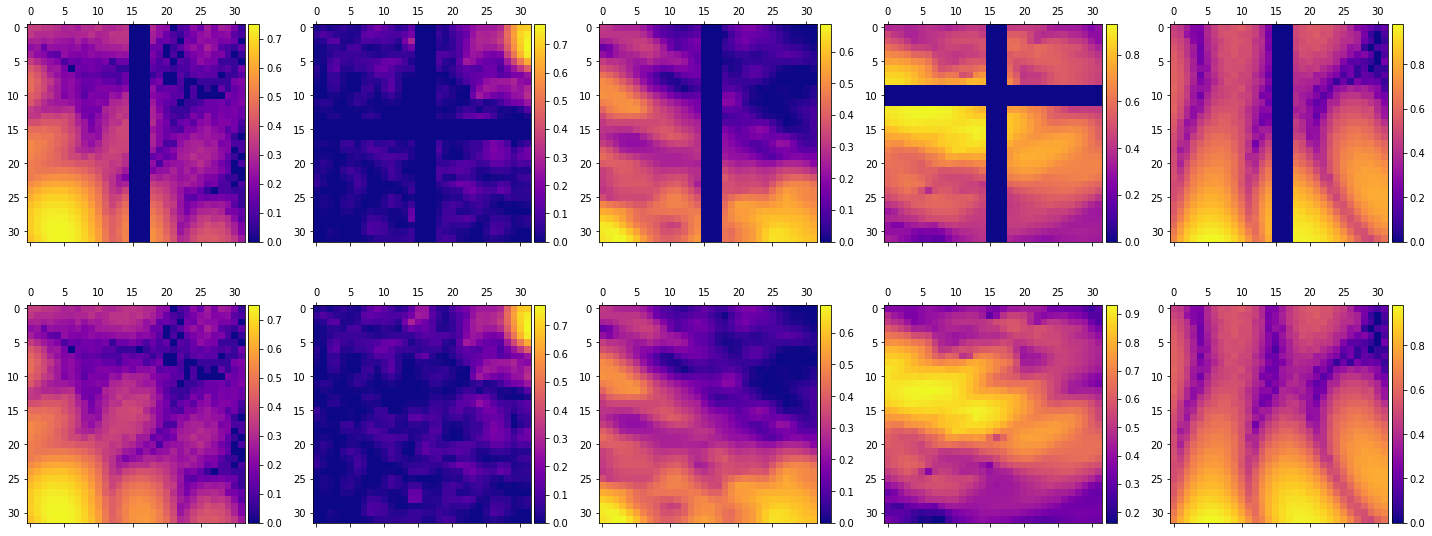

In [10]:
X,y = train_gen.__getitem__(0)

nrow = 2
ncol = 5
fig,ax = plt.subplots(nrow,ncol, figsize=(4*ncol,4*nrow))
for n in range(ncol):
    img = []
    img.append(ax[0,n].matshow(X[n,:,:,16,0]))
    img.append(ax[1,n].matshow(y[n,:,:,16,0]))

    for ii, im in enumerate(img):
        divider = make_axes_locatable(ax[ii,n])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        
fig.tight_layout()

In [3]:
input_shape = (32,32,32,1)

model = build_unet_mod(input_shape)


2023-12-15 17:53:48.185909: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2316000000 Hz
2023-12-15 17:53:48.186489: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x429e63c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-12-15 17:53:48.186504: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-12-15 17:53:48.320637: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x42de3ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-15 17:53:48.320669: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-12-15 17:53:48.321122: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0004:04:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 d

In [4]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss = MyLoss_noisy ) 

In [6]:
model.load_weights('path_where_the_weights_are')

# Run this part if you want to re-train the model

In [19]:
# Just initiate the loss
loss_train = []
loss_val = []

In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.15,
                              patience=4, min_lr=1e-6)


In [21]:
history = model.fit_generator(train_gen,
                              validation_data=val_gen,
                              epochs=30, 
                              callbacks=[reduce_lr] )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30


2023-10-19 18:28:21.761969: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-10-19 18:28:28.316913: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


  4/881 [..............................] - ETA: 12:26 - loss: 2.6001

KeyboardInterrupt: 

# Testing after the training

In [11]:
index = np.random.randint(len(test_gen.list_IDs)//test_gen.batch_size)
X,y_true = test_gen.__getitem__(index)
y_pred = model.predict(X)

mask = y_true[...,1]
y_pred2 = y_pred[...,0]*mask
y_pred2 = y_pred2 + X[...,0]

2023-12-15 17:56:46.211572: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-12-15 17:56:51.449817: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


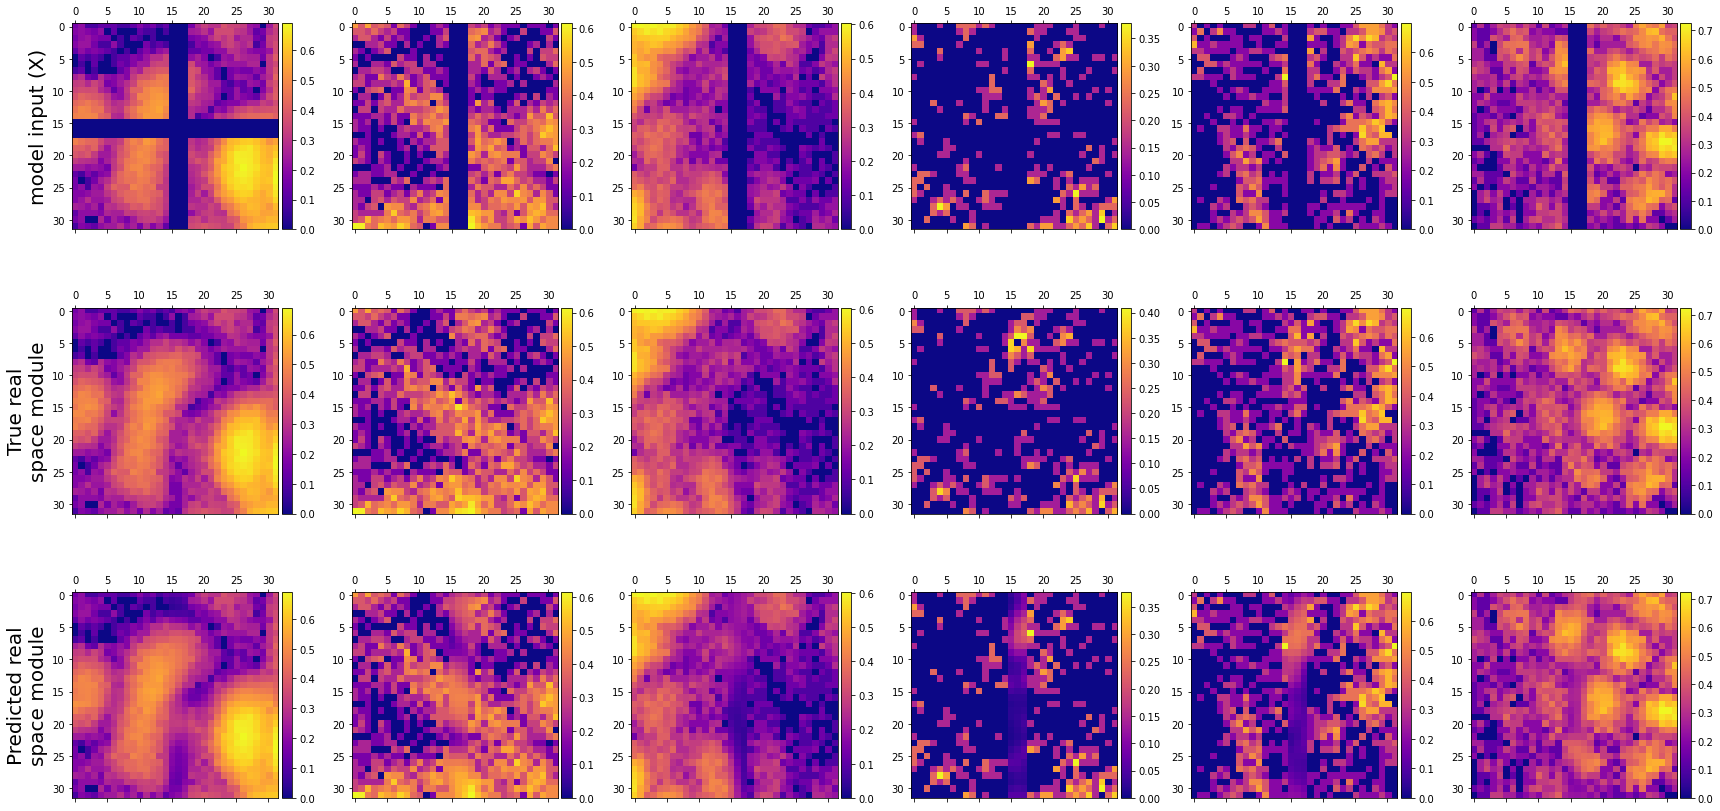

In [12]:
nrow = 3
ncol = 6

fig,ax = plt.subplots(nrow,ncol, figsize=(4*ncol,4*nrow))
for n in range(ncol):
    img = []
    img.append(ax[0,n].matshow(X[n,:,:,16,0]))
    img.append(ax[1,n].matshow(y_true[n,:,:,16,0]))
    img.append(ax[2,n].matshow(y_pred2[n,:,:,16]))
    for ii, img in enumerate(img):
        divider = make_axes_locatable(ax[ii,n])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(img, cax=cax, orientation='vertical')
        
ax[0,0].set_ylabel('model input (X)', fontsize=20)
ax[1,0].set_ylabel('True real\nspace module', fontsize=20)
ax[2,0].set_ylabel('Predicted real\nspace module', fontsize=20)
        
fig.tight_layout()